# InSAR denoiser training, validation, testing

In [1]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import torch
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import seaborn as sns
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import random
from scipy import stats
import pickle

## Dataset construction

In [2]:
main_dir = '/home/jovyan/indennt'
subset_types = ['signal', 'noise', 'dem', 'murp', 'era5']

In [3]:
# exclude non tif files, e.g. metadata
def list_tifs(my_fns):
    my_list = []
    for i in my_fns:
        if i[-4:] == '.tif':
            my_list.append(i)
    return my_list

def subset_lists(main_dir, ds_type, subset_types):
    path_d = {}
    fn_list = []
    for type in subset_types:
        path_d[type] = f'{main_dir}/{ds_type}_subsets/{type}/'
        fn_list.append(list_tifs(os.listdir(path_d[type])))
    return path_d, fn_list[0]

In [4]:
train_d, train_list = subset_lists(main_dir, 'train', subset_types)
val_d, val_list = subset_lists(main_dir, 'val', subset_types)
#test_d, test_list = subset_lists(main_dir, 'test', subset_types)

In [5]:
# define transforms
my_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [6]:
# define dataset 
class dataset(torch.utils.data.Dataset):
    def __init__(self, file_list, path_d, transform=None, 
                 norm=True, center=True, blurnoise=False, flip=False, invert=False):
        self.file_list = file_list
        self.transform = transform
        self.signal_dir = path_d['signal']
        self.noise_dir = path_d['noise']
        self.dem_dir = path_d['dem']
        self.era5_dir = path_d['era5']
        self.murp_dir = path_d['murp']
        self.norm = norm
        self.center = center
        self.blurnoise = blurnoise
        self.flip = flip
        self.invert = invert
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        signal_path = self.signal_dir+self.file_list[idx]
        noise_path = self.noise_dir+self.file_list[idx]
        dem_path = self.dem_dir+self.file_list[idx]
        era5_path = self.era5_dir+self.file_list[idx]
        murp_path = self.murp_dir+self.file_list[idx]
        
        signal = self.transform(Image.open(signal_path))
        noise = self.transform(Image.open(noise_path))
        dem = self.transform(Image.open(dem_path))
        era5 = self.transform(Image.open(era5_path))
        murp = self.transform(Image.open(murp_path))
        
        # Blur noise
        if self.blurnoise == True: # blur noise to mitigate signal from non atmospheric sources
            gblur = transforms.GaussianBlur(kernel_size=(9, 9), sigma=2)
            noise = gblur(noise)
        
        # Generate scaled training images
        scalar = np.round(np.random.lognormal(2, 1), 3) # FOR PLOTTING: 0.2, 0.7
        signal = signal*scalar*-1 #multiply by -1 because mintpy has a reversed sign convention
        igram = noise+signal

        era5_corr = igram-era5
        murp_corr = igram-murp
        
        # correct hp
        hp_filter = transforms.GaussianBlur(kernel_size=(21, 21), sigma=5)
        igram_filtered = hp_filter(igram)
        hp_corr = igram - igram_filtered
        
        if self.invert==True:
            if random.random() < 0.5:
                igram = igram*-1
                signal = signal*-1
                noise = noise*-1
                era5_corr = era5_corr *-1
                murp_corr = murp_corr *-1
                hp_corr = hp_corr *-1
            
        if self.norm == True:
            norm_dict = {}
            norm_dict['norm_min'] = igram.min()
            norm_dict['norm_max'] = igram.max()
                
            igram = 2*(((igram-igram.min())/(igram.max()-igram.min())))-1
            dem = 2*(((dem-dem.min())/(dem.max()-dem.min())))-1
        
        if self.center == True: # center target images on 0 
            center_mean = igram.mean()
            norm_dict['center'] = center_mean
            
            igram = igram-center_mean
            dem = dem - dem.mean()
        
        if self.flip==True:
            flip_dim = []
            if random.random() < 0.25:
                flip_dim = [0]
            elif random.random() > 0.25 and random.random() < 0.5:
                flip_dim = [1]
            elif random.random() > 0.5 and random.random() < 0.75:
                flip_dim = [0, 1]
            
            igram = torch.flip(igram, flip_dim)
            signal = torch.flip(signal, flip_dim)
            era5_corr = torch.flip(era5_corr, flip_dim)
            murp_corr = torch.flip(murp_corr, flip_dim)
            hp_corr = torch.flip(hp_corr, flip_dim)
            dem = torch.flip(dem, flip_dim)
            
         
        return igram, signal, noise, dem, era5_corr, murp_corr, hp_corr, norm_dict

In [7]:
def undo_norm(array, norm_dict, center=True):
    if center==True:
        array = array + norm_dict['center']
    array = ((array+1)*((norm_dict['norm_max']-norm_dict['norm_min'])/2))+norm_dict['norm_min']
    
    return array

In [8]:
# create dataloaders
train_data = dataset(train_list, train_d, transform=my_transforms, blurnoise=True, flip=True, invert=True)
val_data = dataset(val_list, val_d, transform=my_transforms, blurnoise=True)
#test_data = dataset(test_list, test_d, transform=my_transforms, blurnoise=True)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=1, shuffle=True)
#test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=1, shuffle=False)

## Examine dataset

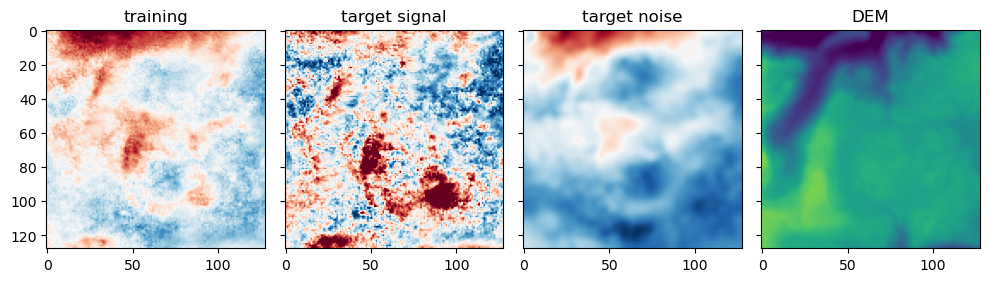

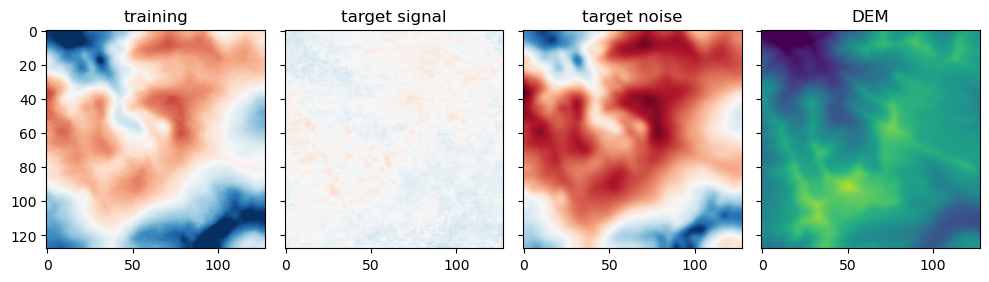

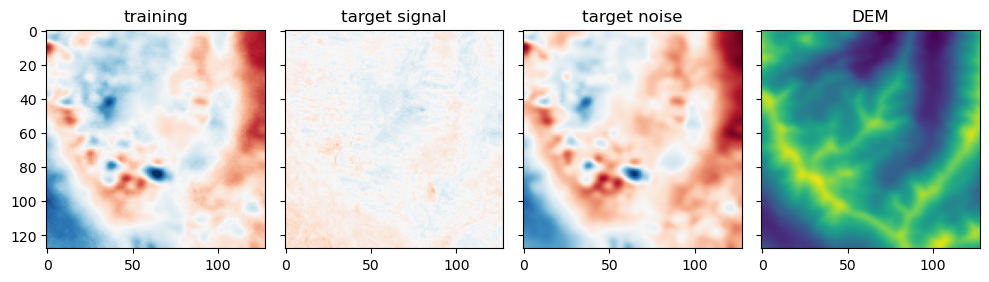

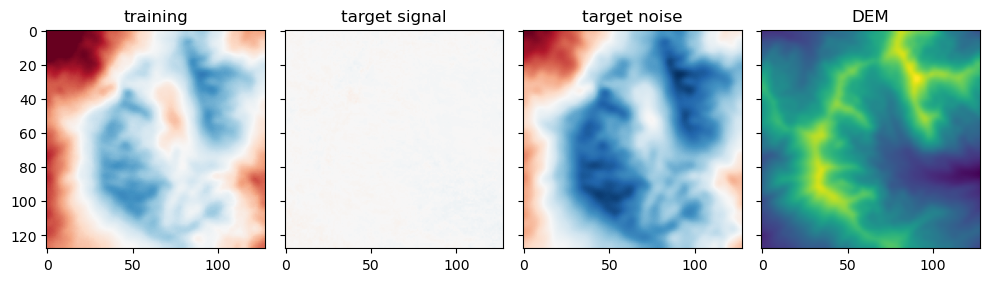

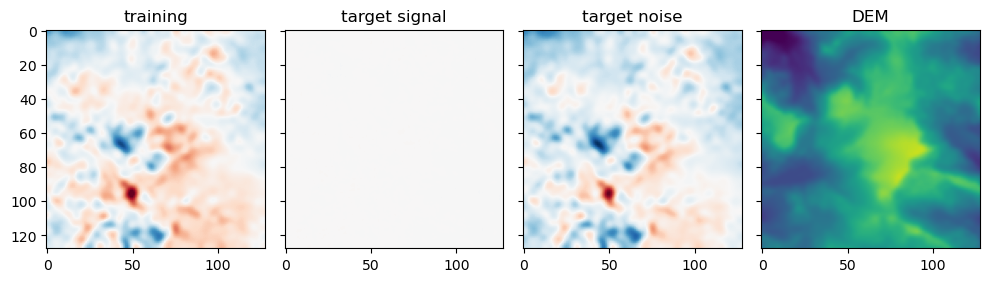

In [9]:
# training inputs 
num_images = 5

for i, (sample, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in enumerate(val_loader):
    if i < num_images:
            f, ax = plt.subplots(1, 4, figsize=(10,4), sharey=True)
            ax[0].imshow(sample.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1, interpolation=None) 
            ax[0].set_title('training')
            ax[1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1, interpolation=None)
            ax[1].set_title('target signal')
            ax[2].imshow(noise_target.squeeze(), cmap='RdBu_r', interpolation=None)
            ax[2].set_title('target noise')
            ax[3].imshow(dem.squeeze(), cmap='viridis', vmin=-1, vmax=1, interpolation=None)
            ax[3].set_title('DEM')
            f.tight_layout()
    else: 
        break

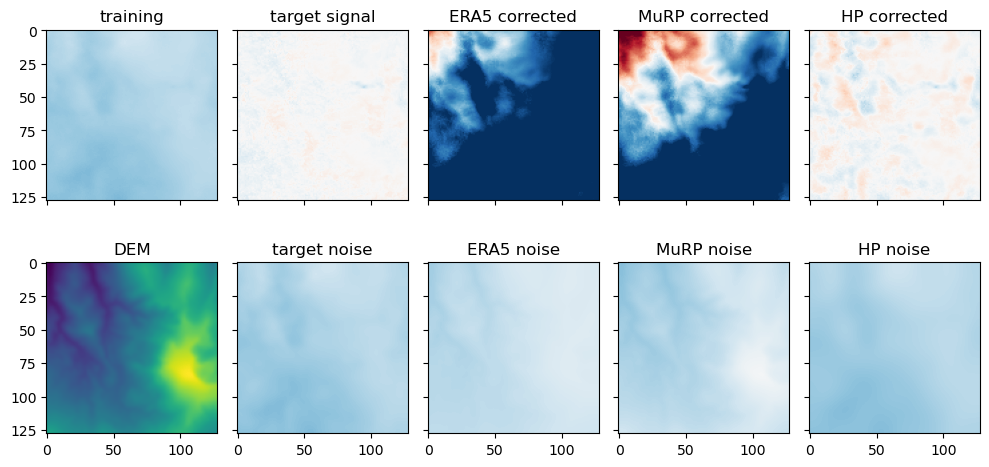

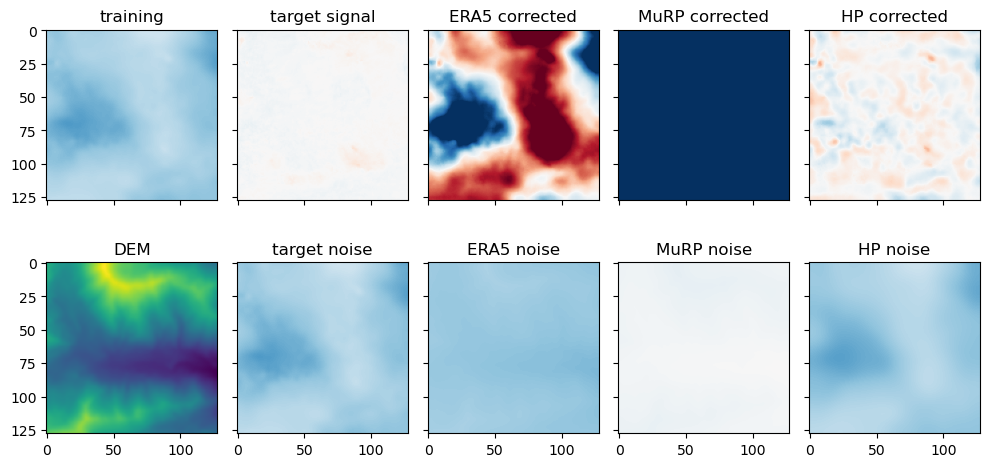

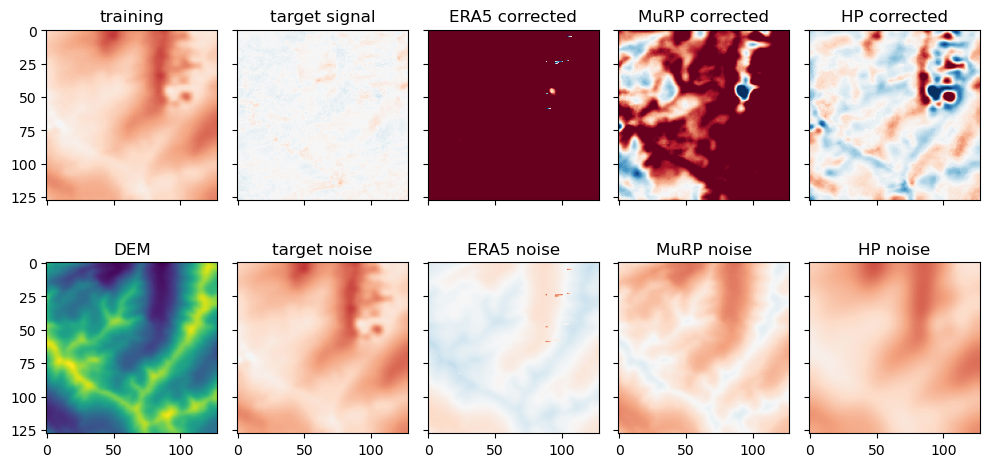

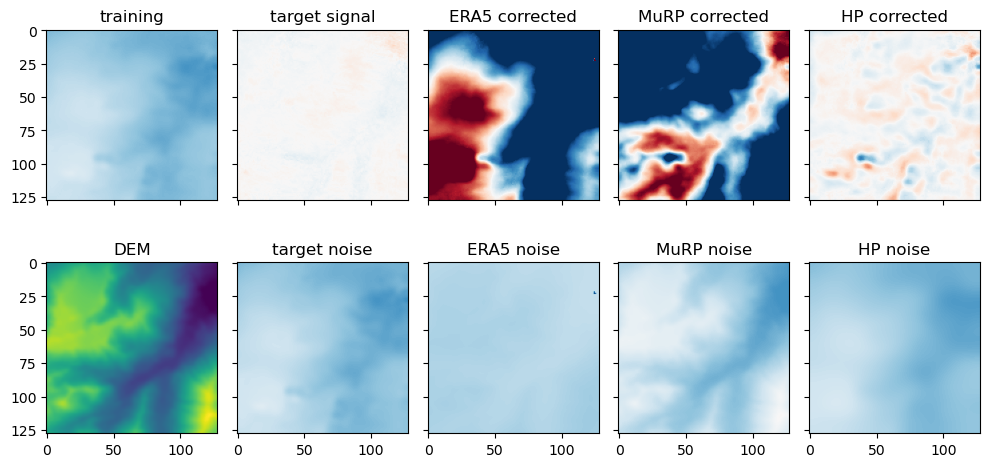

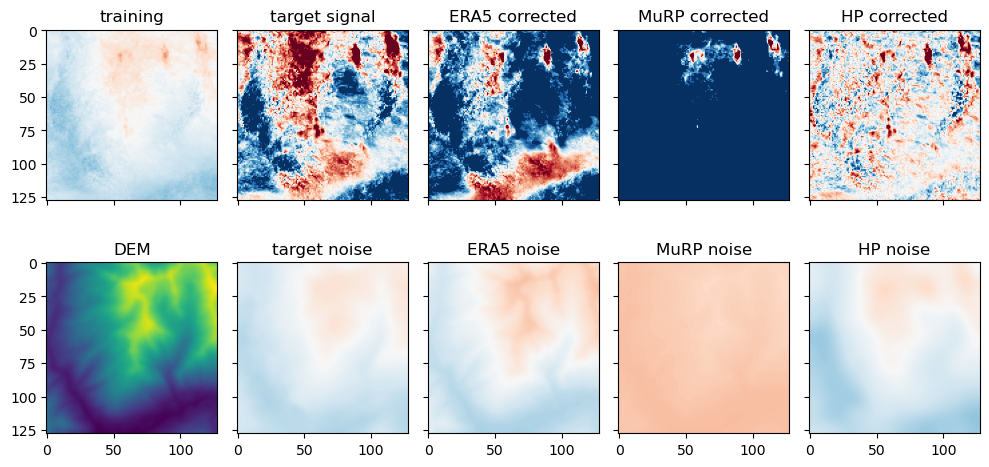

In [10]:
# igram, target signal, corrected igrams
num_images = 5

for i, (sample_norm, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in enumerate(val_loader):
    if i < num_images:
        sample = undo_norm(sample_norm.squeeze(), norm_dict)
        
        f, ax = plt.subplots(2, 5, figsize=(10,5), sharey=True, sharex=True)
        ax[0][0].imshow(sample, cmap='RdBu_r', vmin=-10, vmax=10) 
        ax[0][0].set_title('training')
        ax[0][1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
        ax[0][1].set_title('target signal')
        ax[0][2].imshow(era5_corr.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
        ax[0][2].set_title('ERA5 corrected')
        ax[0][3].imshow(murp_corr.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
        ax[0][3].set_title('MuRP corrected')
        ax[0][4].imshow(hp_corr.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
        ax[0][4].set_title('HP corrected')
        
        ax[1][0].imshow(dem.squeeze(), cmap='viridis') 
        ax[1][0].set_title('DEM')
        ax[1][1].imshow((sample.squeeze() - signal_target.squeeze()), cmap='RdBu_r', vmin=-10, vmax=10)
        ax[1][1].set_title('target noise')
        ax[1][2].imshow((sample.squeeze()-era5_corr.squeeze()), cmap='RdBu_r', vmin=-10, vmax=10)
        ax[1][2].set_title('ERA5 noise')
        ax[1][3].imshow((sample.squeeze()-murp_corr.squeeze()), cmap='RdBu_r', vmin=-10, vmax=10)
        ax[1][3].set_title('MuRP noise')
        ax[1][4].imshow((sample.squeeze()-hp_corr.squeeze()), cmap='RdBu_r', vmin=-10, vmax=10)
        ax[1][4].set_title('HP noise')
        f.tight_layout()
    else:
        break
            
            #plt.savefig(f'input_correctons{i}.png', dpi=300)

## Define network

In [11]:
def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=True):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding, bias=bias)


def conv1x1(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)


def check_valid_activation(choice):
    if choice not in ['relu', 'lrelu', 'prelu']:
        raise ValueError(f"'{choice}' is not a valid activation function. Choose among ['relu', 'lrelu', 'prelu'].\n")


def upconv(in_channels, out_channels, mode='transpose'):
    # stride=2 implies upsampling by a factor of 2
    get_up_mode = nn.ModuleDict([
        ['bilinear', nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2), conv1x1(in_channels, out_channels))],
        ['transpose', nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)]
    ])

    return get_up_mode[mode]


def get_activation(choice):
    activation_functions = nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['lrelu', nn.LeakyReLU(inplace=True)],
        ['prelu', nn.PReLU()]
        ])
    return activation_functions[choice]


def conv_block(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Partial encoder block consisting of a 3×3 convolutional layer with stride 1, followed by batch normalization
    (optional) and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


def conv_up_block(in_channels, out_channels, activation='relu', do_BN=True, up_mode='transpose', *args, **kwargs):
    """
    Decoder block consisting of an up-convolutional layer, followed by a 3×3 convolutional layer with stride 1,
    batch normalization (optional), and a non-linear activation function.
    """

    if do_BN:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                get_activation(activation))
            )
    else:
        return nn.Sequential(
            upconv(in_channels, in_channels, up_mode),
            nn.Sequential(
                conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
                get_activation(activation))
            )


def bottleneck(in_channels, out_channels, activation='relu', do_BN=True, *args, **kwargs):
    """
    Bottleneck block.
    """

    if do_BN:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=False, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            get_activation(activation)
        )
    else:
        return nn.Sequential(
            conv3x3(in_channels, out_channels, bias=True, *args, **kwargs),
            get_activation(activation)
        )


class SkipConnection(nn.Module):
    def __init__(self):
        super(SkipConnection, self).__init__()

    def forward(self, x_skip, x_up):
        return x_skip + x_up


class UNet(nn.Module):
    def __init__(self, n_input_channels=2, start_kernel=64, max_filter_depth=512, depth=5,
                 act_fn_encoder='relu', act_fn_decoder='relu', act_fn_bottleneck='relu', up_mode='transpose',
                 do_BN=False, bias_conv_layer=False, outer_skip=True, outer_skip_BN=False):
        """
        UNet network architecture.
        :param n_input_channels:    int, number of input channels
        :param start_kernel:        int, number of filters of the first convolutional layer in the encoder
        :param max_filter_depth:    int, maximum filter depth
        :param depth:               int, number of downsampling and upsampling layers (i.e., number of blocks in the
                                    encoder and decoder)
        :param act_fn_encoder:      str, activation function used in the encoder
        :param act_fn_decoder:      str, activation function used in the decoder
        :param act_fn_bottleneck:   str, activation function used in the bottleneck
        :param up_mode:             str, upsampling mode
        :param do_BN:               boolean, True to perform batch normalization after every convolutional layer,
                                    False otherwise
        :param bias_conv_layer:     boolean, True to activate the learnable bias of the convolutional layers,
                                    False otherwise
        :param outer_skip:          boolean, True to activate the long residual skip connection that adds the
                                    initial DSM to the output of the last decoder layer, False otherwise
        :param outer_skip_BN:       boolean, True to add batch normalization to the long residual skip connection,
                                    False otherwise
        """

        super(UNet, self).__init__()

        check_valid_activation(act_fn_encoder)
        check_valid_activation(act_fn_decoder)
        check_valid_activation(act_fn_bottleneck)

        if up_mode not in ['transpose', 'bilinear']:
            raise ValueError(f"'{up_mode}' is not a valid mode for upsampling. Choose among ['transpose', 'bilinear'] "
                             "to specify 'up_mode'.\n")

        self.n_input_channels = n_input_channels
        self.start_kernel = start_kernel
        self.depth = depth
        self.act_fn_encoder = act_fn_encoder
        self.act_fn_decoder = act_fn_decoder
        self.act_fn_bottleneck = act_fn_bottleneck
        self.up_mode = up_mode
        self.max_filter_depth = max_filter_depth
        self.do_BN = do_BN
        self.bias_conv_layer = bias_conv_layer
        self.do_outer_skip = outer_skip
        self.do_outer_skip_BN = outer_skip_BN
        self.filter_depths = [self.start_kernel * (2 ** i) for i in range(self.depth)]

        # Restrict the maximum filter depth to a predefined value
        self.filter_depths = [self.max_filter_depth if i > self.max_filter_depth else i for i in self.filter_depths]

        # Set up the encoder
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Sequential(
            conv_block(self.n_input_channels, self.start_kernel, activation=self.act_fn_encoder, do_BN=self.do_BN),
            nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        for in_channel, out_channel in zip(self.filter_depths, self.filter_depths[1:]):
            self.encoder.append(nn.Sequential(
                conv_block(in_channel, out_channel, activation=self.act_fn_encoder, do_BN=self.do_BN),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ))

        # Set up the bottleneck
        self.bottleneck = bottleneck(self.filter_depths[-1], self.filter_depths[-1], activation=self.act_fn_bottleneck,
                                     do_BN=self.do_BN)

        # Set up the decoder
        self.decoder = nn.ModuleList()
        self.filter_depths_up = list(reversed(self.filter_depths))

        for in_channel, out_channel in zip(self.filter_depths_up[:-1], self.filter_depths_up[1:]):
            self.decoder.append(conv_up_block(in_channel, out_channel, activation=self.act_fn_decoder,
                                              up_mode=self.up_mode, do_BN=self.do_BN))
        self.decoder.append(upconv(self.filter_depths_up[-1], self.filter_depths_up[-1], up_mode))

        # Set up the final layer of the decoder
        self.last_layer = conv3x3(self.start_kernel, 1, bias=self.bias_conv_layer)

        # Skip connection
        self.skipconnect = SkipConnection()

        # Batch normalization added to the long residual skip connection
        if self.do_outer_skip:
            self.layer_outer_skip = nn.ModuleList()
            if self.do_outer_skip_BN:
                self.layer_outer_skip.append(nn.BatchNorm2d(1))
            self.layer_outer_skip.append(SkipConnection())

    def forward(self, x, dem):
        skip_connections = []
        x = torch.cat((x, dem), dim=1)
        out = x

        # Encoder (save intermediate outputs for skip connections)
        for index, layer in enumerate(self.encoder):
            layer_conv = layer[:-1]  # all layers before the pooling layer (at depth index)
            layer_pool = layer[-1]   # pooling layer (at depth index)

            out_before_pool = layer_conv(out)
            skip_connections.append(out_before_pool)
            out = layer_pool(out_before_pool)

        # Bottleneck
        out = self.bottleneck(out)

        # Decoder + skip connections
        index_max = len(self.decoder) - 1
        for index, layer in enumerate(self.decoder):
            if index <= index_max - 1:
                layer_upconv = layer[0]  # upconv layer
                layer_conv = layer[1::]  # all other layers (conv, batchnorm, activation)

                out_temp = layer_upconv(out)
                out = self.skipconnect(skip_connections[-1 - index], out_temp)
                out = layer_conv(out)
            else:
                out_temp = layer(out)   # upconv of last layer
                out = self.skipconnect(skip_connections[-1 - index], out_temp)

        # Last layer of the decoder
        out = self.last_layer(out)

        # Add long residual skip connection
        if self.do_outer_skip:
            if self.layer_outer_skip.__len__() == 2:
                # pipe input through a batch normalization layer before adding it to the output of the last
                # decoder layer
                bn = self.layer_outer_skip[0]
                x_0 = x[:, 0, :, :]       # use channel 0 only
                x_0 = x_0.unsqueeze(1)
                x = bn(x_0)

            # add (batchnorm) input to the output of the last decoder layer
            add = self.layer_outer_skip[-1]
            x_0 = x[:, 0, :, :]
            x_0 = x_0.unsqueeze(1)

            out = add(x_0, out)  # use channel 0 only

        return out

## Train model

In [ ]:
# #load previous model
# model = UNet()
# model.load_state_dict(torch.load('../models/noisemodel1.1_100epochs'))
# model.to('cuda')
# model.eval()

In [12]:
%%time

#Define optimizer
model = UNet()
model.to('cuda') # run on gpu
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.02) # usual learning rate 0.0002
loss_fn   = nn.L1Loss()
epochs = 150
torch.autograd.set_detect_anomaly(True)

train_loss = []
val_loss = []

for epoch in range(epochs):
    print(f'\nstarting epoch {epoch}')
    epoch_loss=[]
    val_temp_loss = []
    
    #if epoch == 10:
        #optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001) # reduce loss as given epoch
    
    #loop through training data 
    for (sample, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in train_loader:
        model.train()
        optimizer.zero_grad()
        out = torch.clamp(model(sample.to('cuda'), dem.to('cuda')), -1, 1) # Generate noise predictions
    
        # calculate predicted signals 
        signal_pred = sample.to('cuda')-out.to('cuda')
        
        loss = loss_fn(signal_pred.to('cuda'), signal_target.to('cuda')) # calculate loss 
        epoch_loss.append(loss.item()) # add batch loss to epoch loss list
        
        loss.backward() #Propagate the gradients in backward pass
        optimizer.step() 

    train_loss.append(np.mean(epoch_loss))
    print(f'training loss: {np.mean(epoch_loss)}')
    
    # run model on validation data 
    for (sample, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in val_loader:
        with torch.no_grad():
            model.eval()
            out = torch.clamp(model(sample.to('cuda'), dem.to('cuda')), -1, 1) #Generate predictions using the model
            
            signal_pred = sample.to('cuda')-out.to('cuda')
           
            loss = loss_fn(signal_pred.to('cuda'), signal_target.to('cuda')) #Loss/error
            val_temp_loss.append(loss.item())
    
    val_loss.append(np.mean(val_temp_loss))
    print(f'validation loss: {np.mean(val_temp_loss)}')
    
    if (epoch+1)%5 == 0: 
        # save model
        torch.save(model.state_dict(), f'../models/noisemodel1.2_{epoch+1}epochs')
        
    with open('../loss/val_loss.pkl', 'wb') as f:
        pickle.dump(val_loss, f)
        
    with open('../loss/train_loss.pkl', 'wb') as f:
        pickle.dump(train_loss, f)


starting epoch 0
training loss: 0.061639782544944934
validation loss: 0.05889764063990346

starting epoch 1
training loss: 0.059150375577705104
validation loss: 0.05672976886265461

starting epoch 2
training loss: 0.05822738642552508
validation loss: 0.056854305338756385

starting epoch 3
training loss: 0.05595874083688075
validation loss: 0.05128008096273459

starting epoch 4
training loss: 0.05549149620126885
validation loss: 0.05203002702191062

starting epoch 5
training loss: 0.05570856320308002
validation loss: 0.05224624444047106

starting epoch 6
training loss: 0.054998673814400836
validation loss: 0.05220512449837982

starting epoch 7
training loss: 0.05405799869863644
validation loss: 0.05099687132023251

starting epoch 8
training loss: 0.05375052229081612
validation loss: 0.05240212671078967

starting epoch 9
training loss: 0.05366243166217476
validation loss: 0.052733894908148754

starting epoch 10
training loss: 0.05416391709971326
validation loss: 0.052339796005967915

st

## Examine results

In [ ]:
random.seed(10)

In [ ]:
# with open('../loss/val_loss.pkl', 'wb') as f:
#     pickle.load(val_loss, f)
        
# with open('../loss/train_loss.pkl', 'wb') as f:
#     pickle.load(train_loss, f)

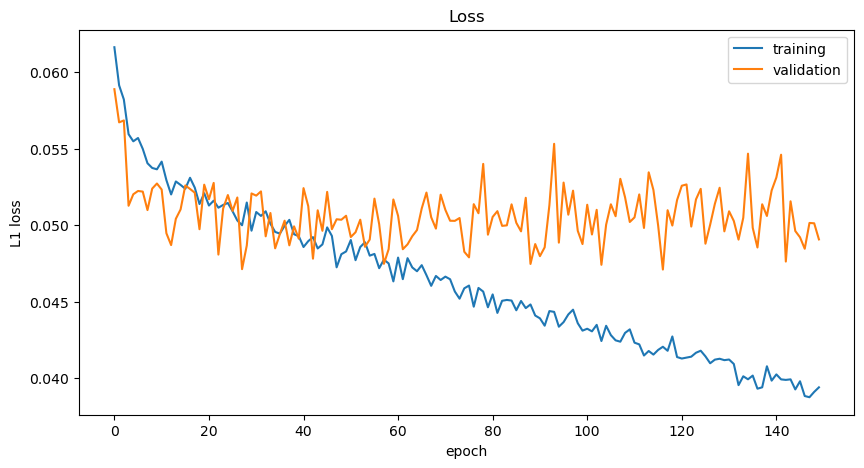

In [13]:
#plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('L1 loss')
ax.set_title('Loss')
ax.legend()
plt.savefig('loss.png', dpi=300)

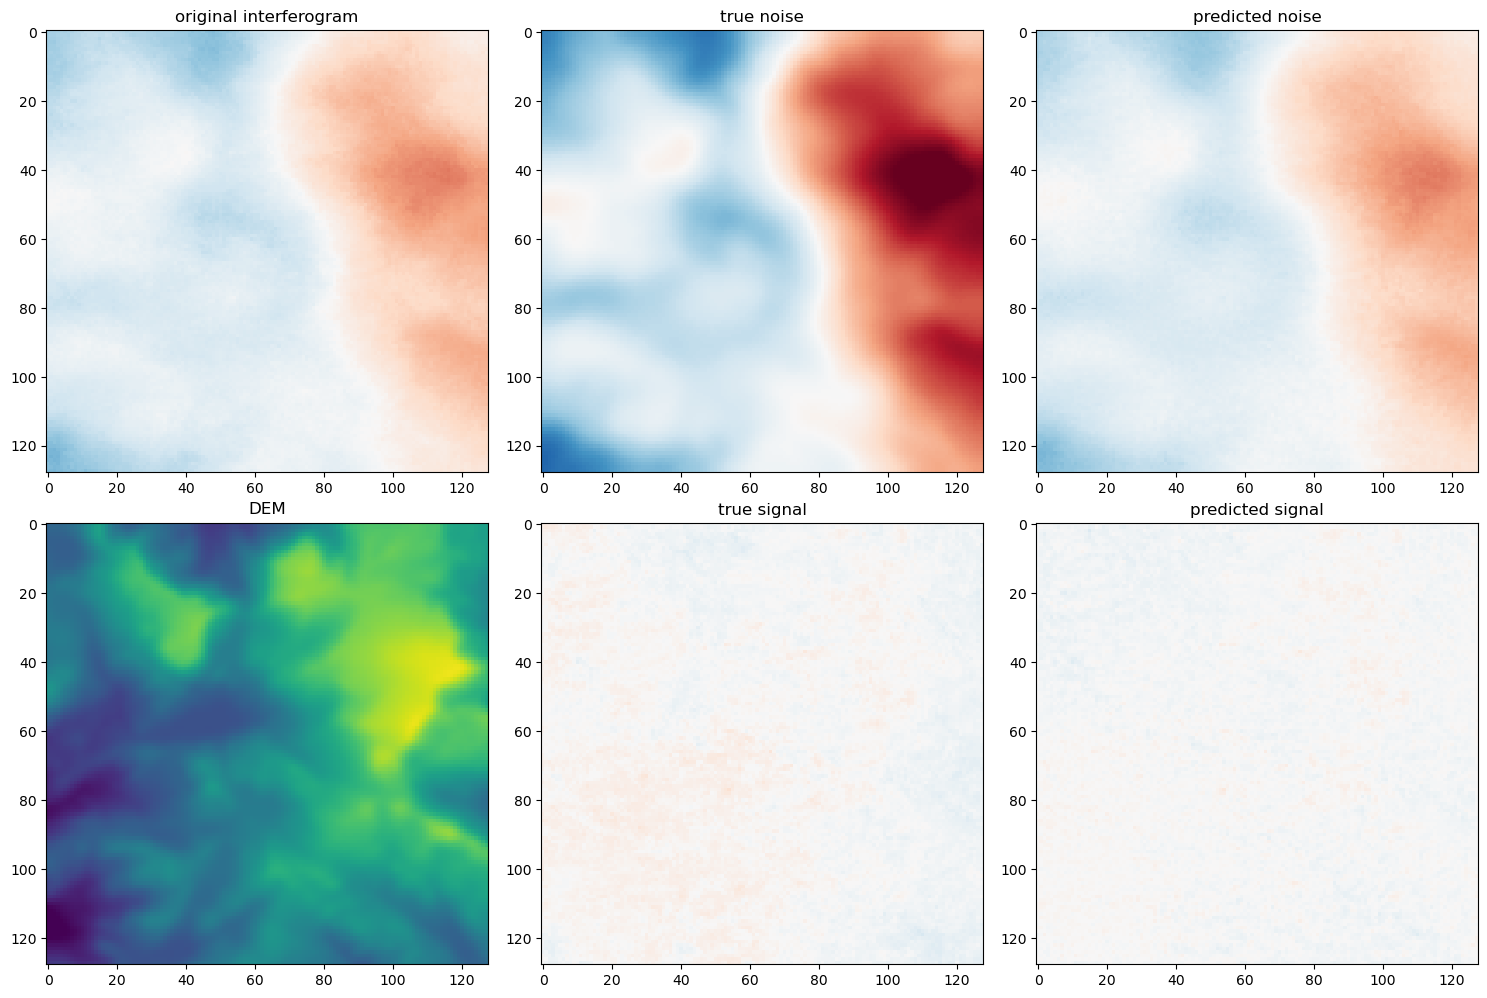

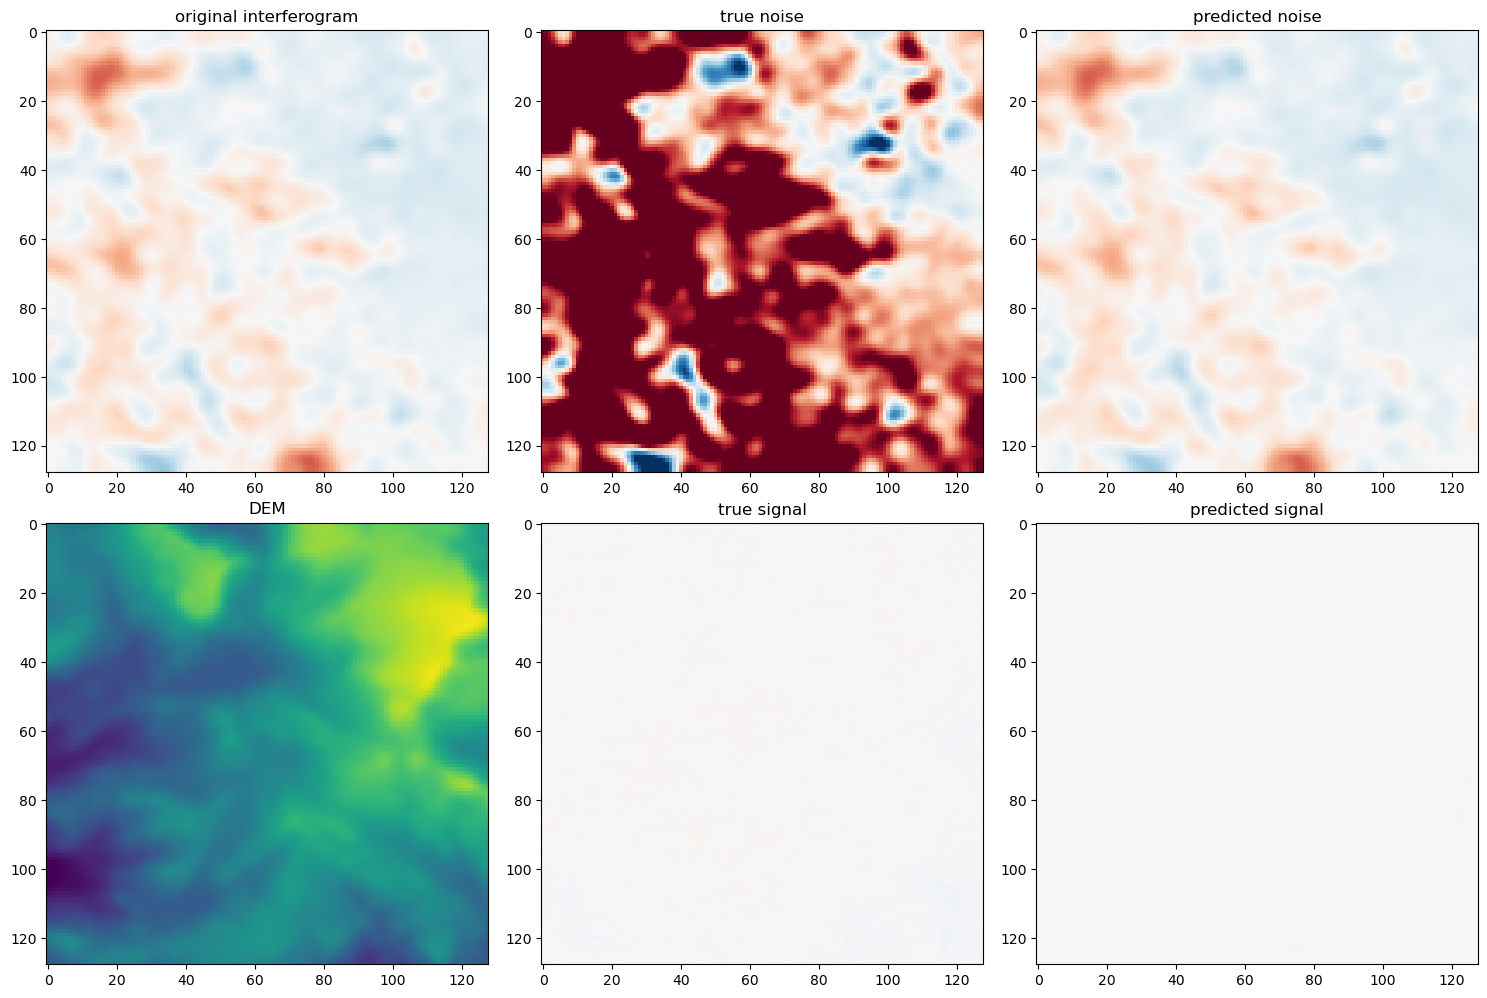

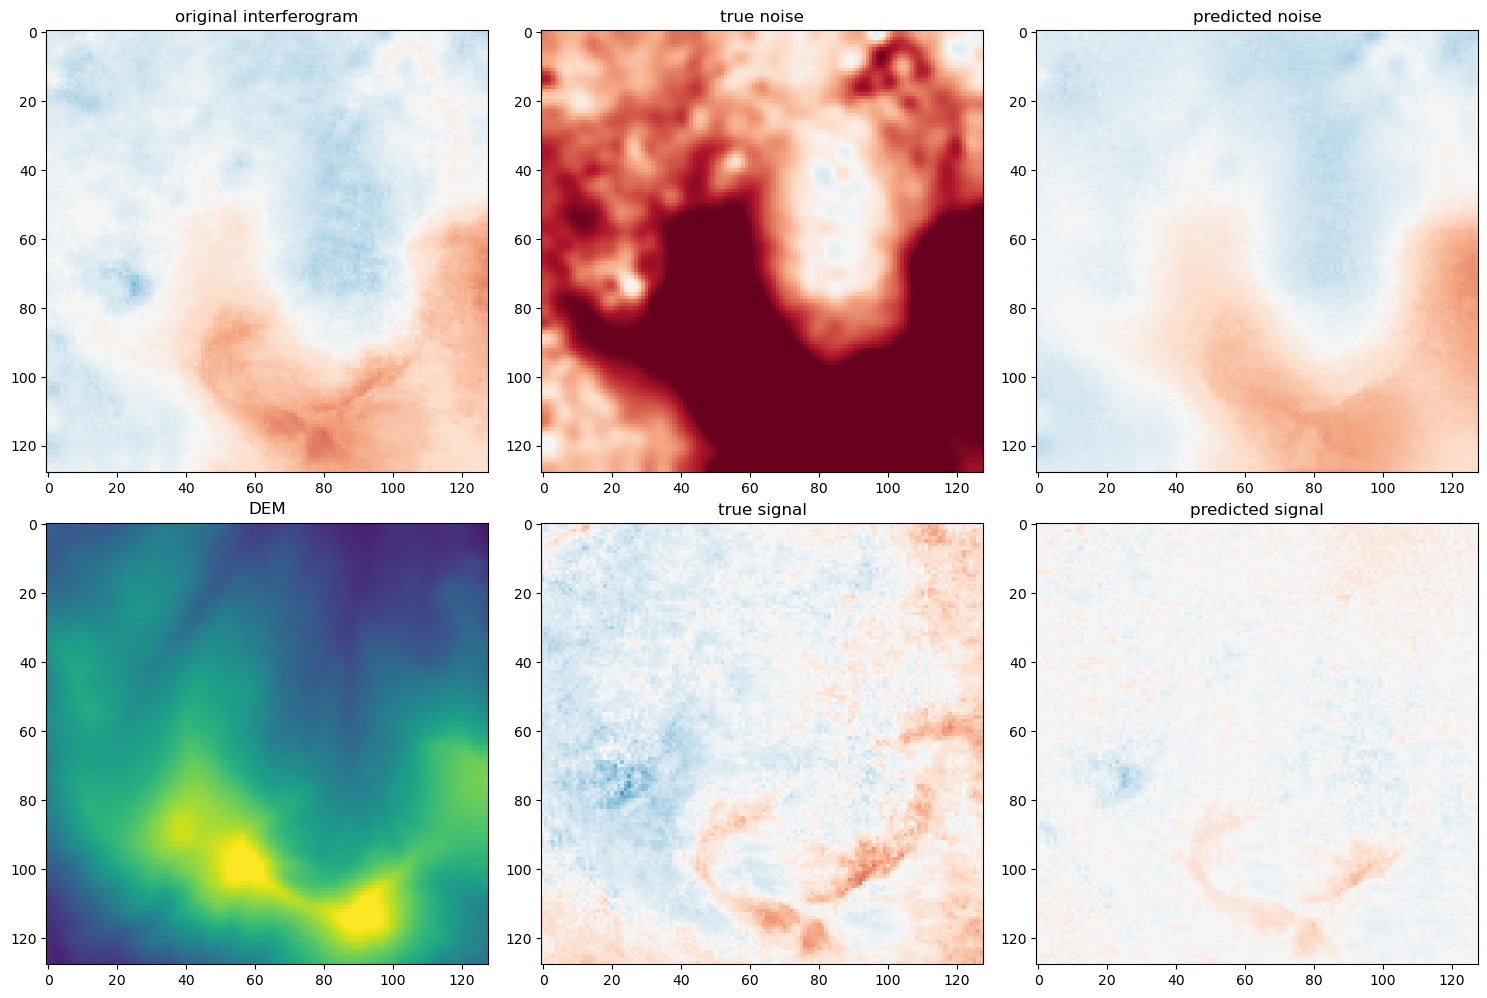

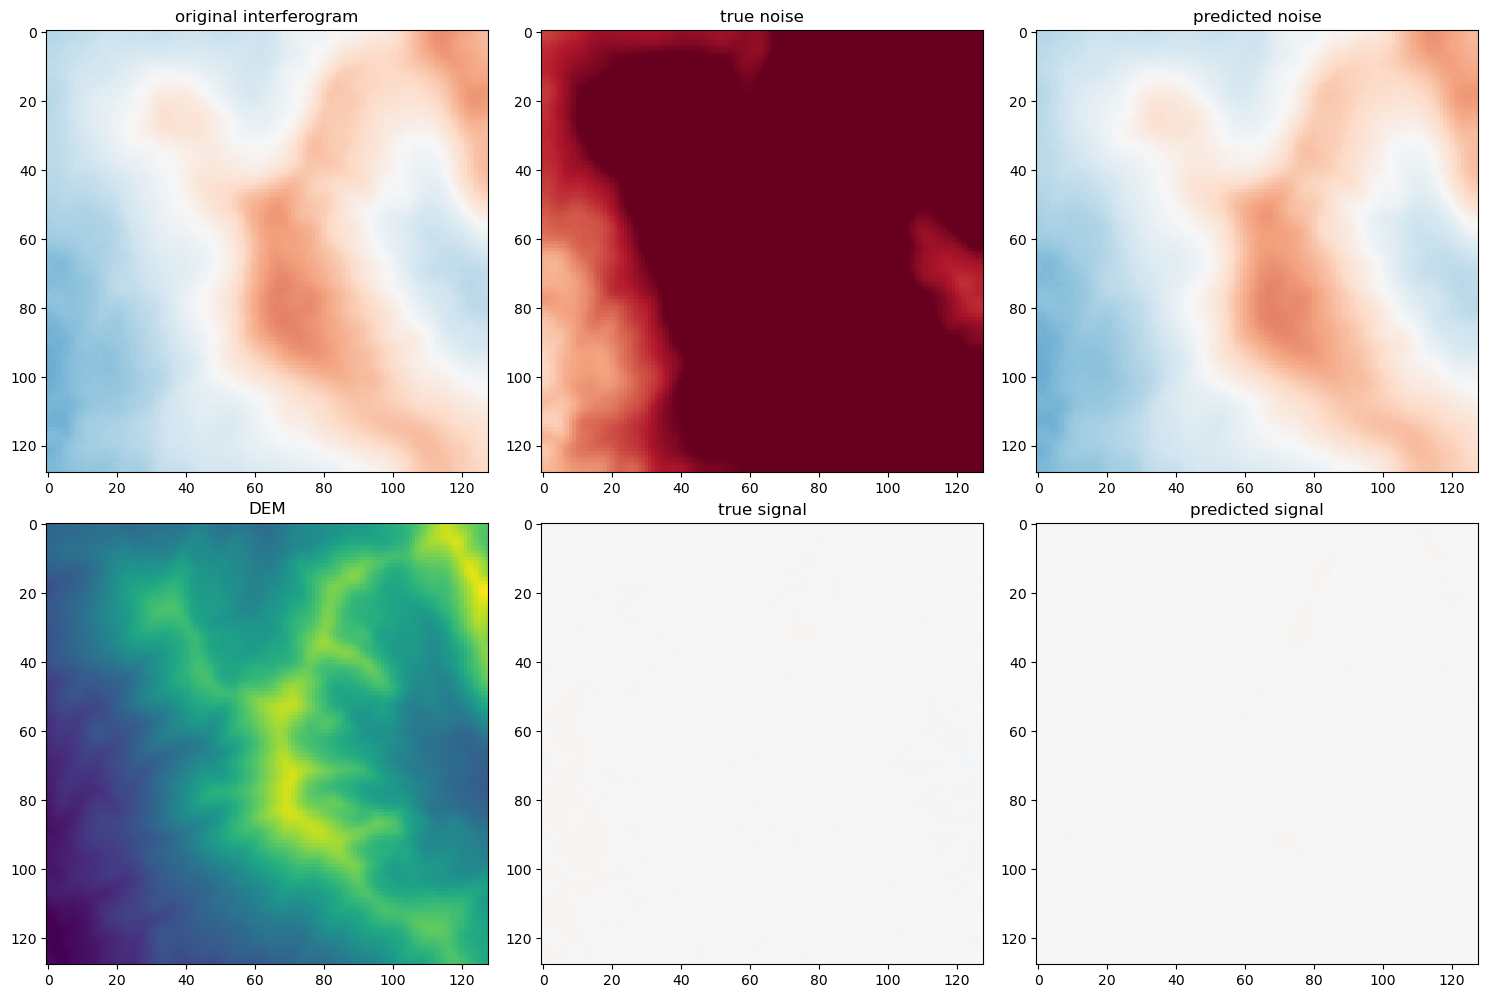

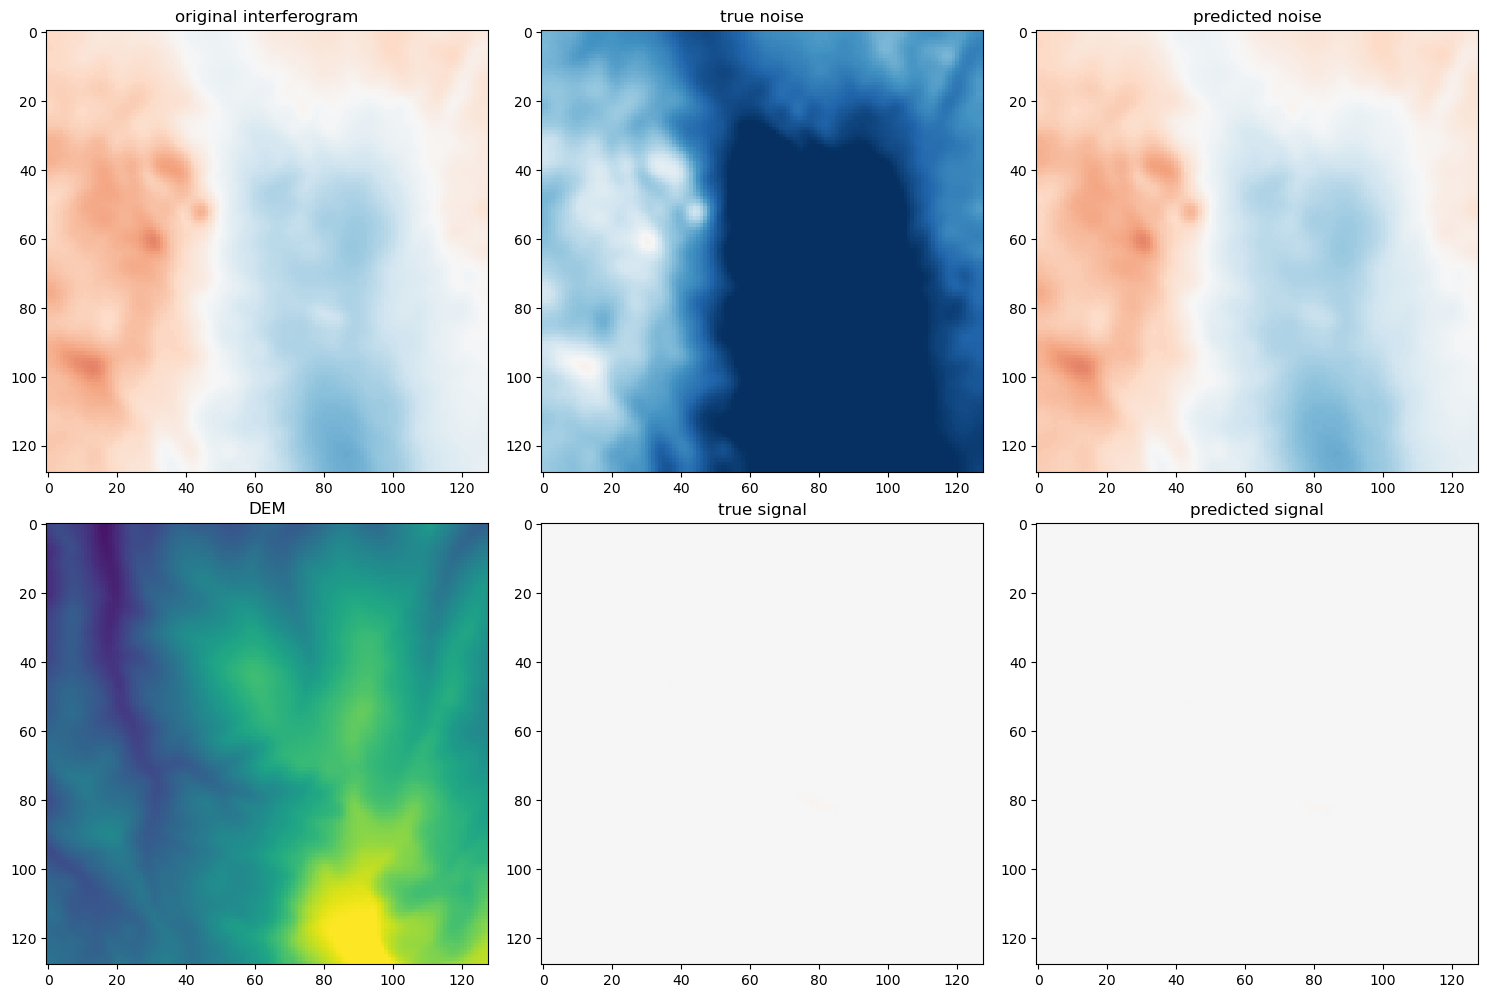

In [14]:
# raw inputs and outputs
num_images=5

for i, (sample, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in enumerate(val_loader):
    if i < num_images:
        with torch.no_grad():
            noise = model(sample.to('cuda'), dem.to('cuda')) #Generate predictions using the model
            signal = torch.clamp(sample.to('cpu') - noise.to('cpu'), -1, 1)
            f, ax = plt.subplots(2, 3, figsize=(15,10))
            ax[0][0].imshow(sample.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2) 
            ax[0][0].set_title('original interferogram')
            ax[0][1].imshow(noise_target.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0][1].set_title('true noise')
            ax[0][2].imshow(noise.squeeze().to('cpu'), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[0][2].set_title('predicted noise')
            ax[1][0].imshow(dem.squeeze().to('cpu'), cmap='viridis', vmin=-1, vmax=1)
            ax[1][0].set_title('DEM')
            ax[1][1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1][1].set_title('true signal')
            ax[1][2].imshow(signal.squeeze(), cmap='RdBu_r', vmin=-2, vmax=2)
            ax[1][2].set_title('predicted signal')
  
            plt.tight_layout()
            #plt.savefig(f'pred_raw{i}.png', dpi=300)
    else: 
        break
            

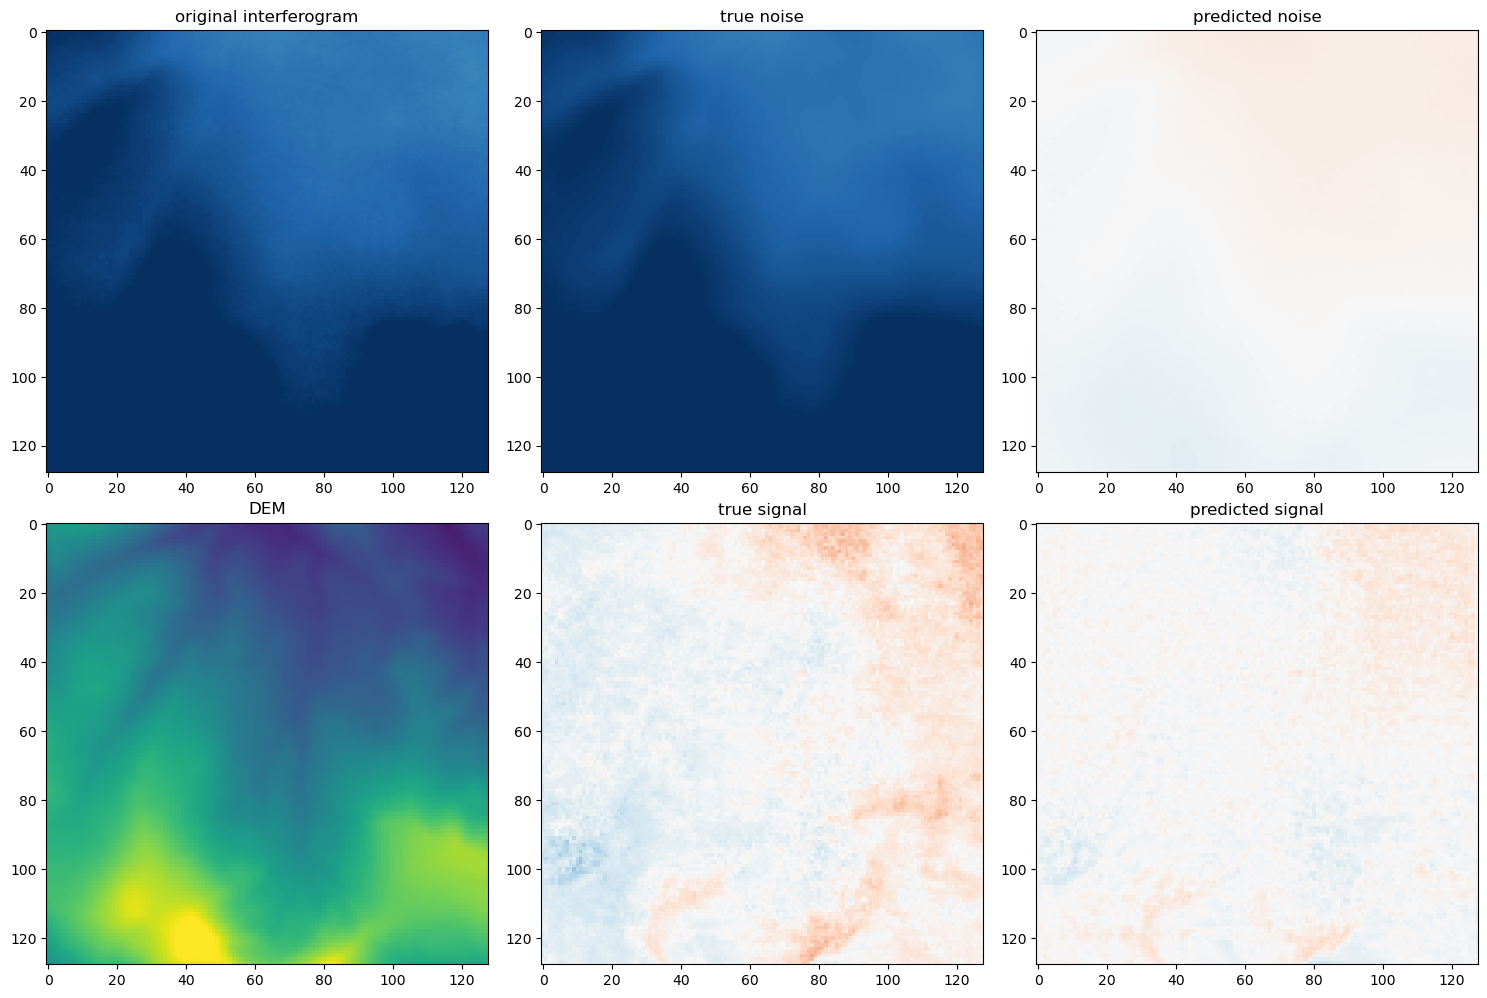

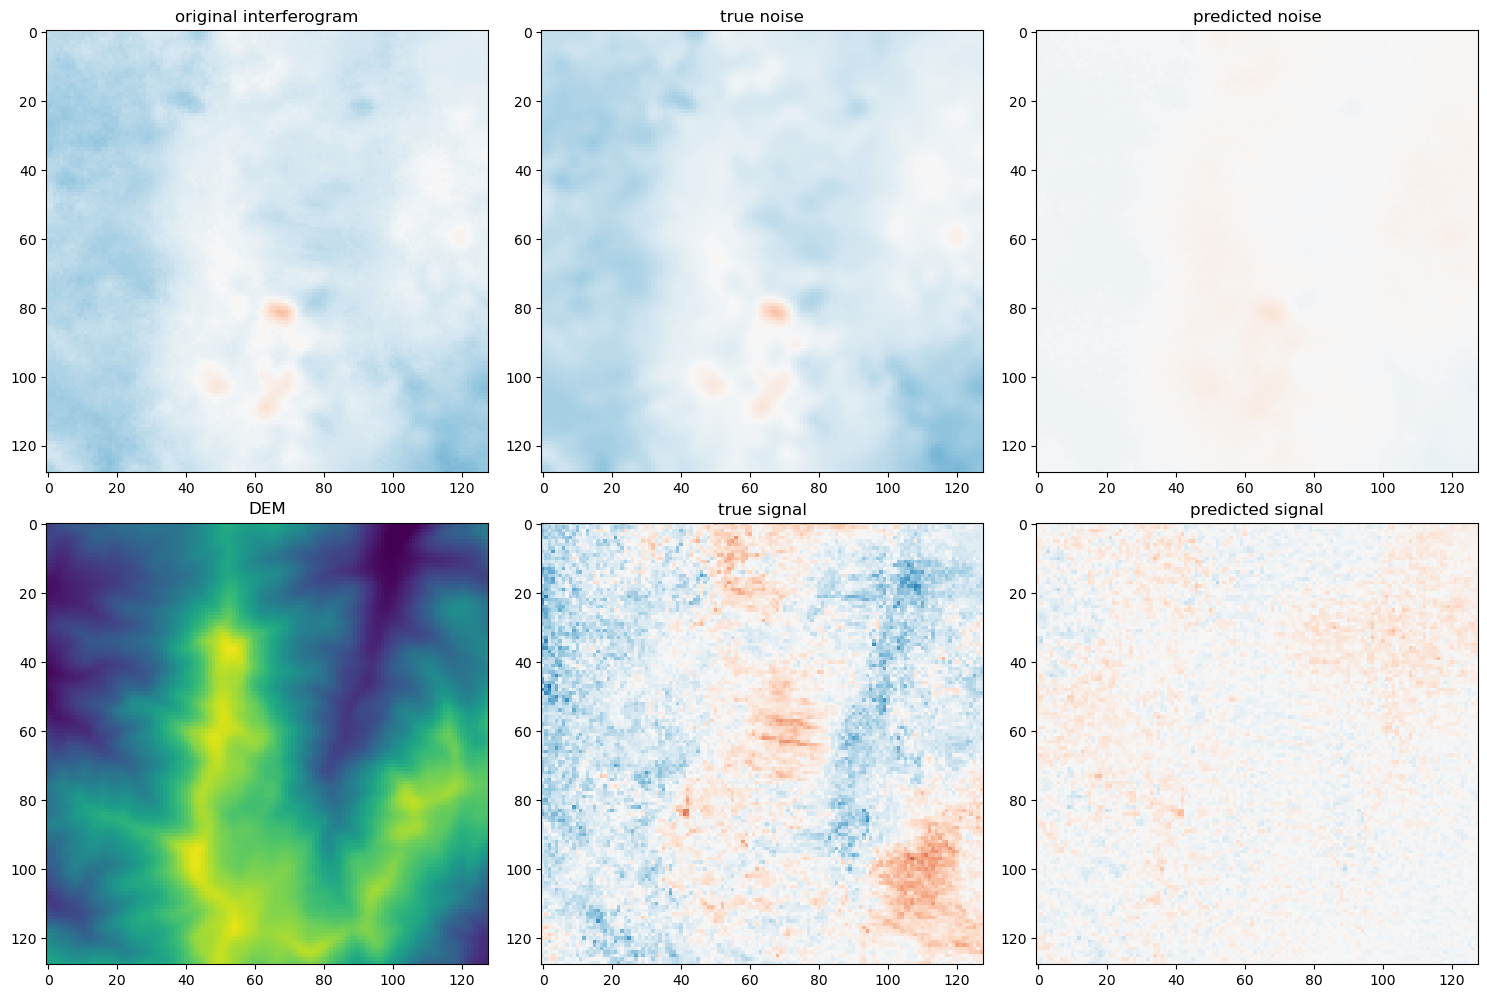

In [ ]:
# un-normalized inputs and outputs
for i, (sample, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in enumerate(val_loader):
    if i < num_images:
        with torch.no_grad():
            noise = model(sample.to('cuda'), dem.to('cuda')) #Generate predictions using the model
            signal = torch.clamp(sample.to('cpu') - noise.to('cpu'), -1, 1)
            
            sample = undo_norm(sample.squeeze(), norm_dict)
            
            f, ax = plt.subplots(2, 3, figsize=(15,10))
            ax[0][0].imshow(sample, cmap='RdBu_r', vmin=-10, vmax=10) 
            ax[0][0].set_title('original interferogram')
            ax[0][1].imshow(noise_target.squeeze(), cmap='RdBu_r', vmin=-10, vmax=10)
            ax[0][1].set_title('true noise')
            ax[0][2].imshow(noise.squeeze().to('cpu'), cmap='RdBu_r', vmin=-10, vmax=10)
            ax[0][2].set_title('predicted noise')
            ax[1][0].imshow(dem.squeeze().to('cpu'), cmap='viridis', vmin=-1, vmax=1)
            ax[1][0].set_title('DEM')
            ax[1][1].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
            ax[1][1].set_title('true signal')
            ax[1][2].imshow(signal.squeeze(), cmap='RdBu_r', vmin=-1, vmax=1)
            ax[1][2].set_title('predicted signal')
            
            plt.tight_layout()
            #plt.savefig(f'pred_raw{i}.png', dpi=300)
    else:
        break

## Evaluate results with training and validation

In [16]:
# define dataloaders for evaluation
val_data_ssim = dataset(val_list, val_d, transform=my_transforms, blurnoise=True, center=True)
train_data_ssim = dataset(train_list, train_d, transform=my_transforms, blurnoise=True, center=True)
val_loader_ssim = torch.utils.data.DataLoader(dataset = val_data_ssim, batch_size=1, shuffle=True)
train_loader_ssim = torch.utils.data.DataLoader(dataset = train_data_ssim, batch_size=1, shuffle=True)

In [17]:
def ssim_lists(model, data_loader):
    # initialize lists 
    ssim_list_uncorrected = []
    ssim_list_model = []
    ssim_list_era5 = []
    ssim_list_murp = []
    ssim_list_hp = []
    
    for i, (sample, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in enumerate(data_loader):
        # uncorrected SSIM
        # denormalize
        sample_raw = undo_norm(sample.squeeze().detach(), norm_dict)
        # calc ssim
        ssim_value_uncorrected = ssim(sample_raw.numpy(), signal_target.squeeze().numpy(), gaussian_weights=True)
        ssim_list_uncorrected.append(ssim_value_uncorrected)
    
        # model corrected SSIM
        # model preds
        noise = model(sample.to('cuda'), dem.to('cuda')) #Generate predictions using the model
        signal = torch.clamp(sample.to('cpu') - noise.to('cpu'), -1, 1)
        # denormalize
        signal = undo_norm(signal.squeeze().detach(), norm_dict)
        # calc ssim
        ssim_value_model = ssim(signal.numpy(), signal_target.squeeze().numpy(), gaussian_weights=True)
        ssim_list_model.append(ssim_value_model)
    
        # era5 corrected SSIM
        ssim_value_era5 = ssim(era5_corr.squeeze().numpy(), signal_target.squeeze().numpy(),gaussian_weights=True)
        ssim_list_era5.append(ssim_value_era5)

        # murp corrected SSIM
        ssim_value_murp = ssim(murp_corr.squeeze().numpy(), signal_target.squeeze().numpy(),gaussian_weights=True)
        ssim_list_murp.append(ssim_value_murp)
    
        # hp filter corrected SSIM
        ssim_value_hp = ssim(hp_corr.squeeze().numpy(), signal_target.squeeze().numpy(), gaussian_weights=True)
        ssim_list_hp.append(ssim_value_hp)
    
    print('median ssim before correction:', np.median(ssim_list_uncorrected),
          '\nmedian ssim model correction:', np.median(ssim_list_model), 
          '\nmedian ssim era5 correction:', np.median(ssim_list_era5),
          '\nmedian ssim murp correction:', np.median(ssim_list_murp),
          '\nmedian ssim high pass filter correction:', np.median(ssim_list_hp))
    
    return ssim_list_uncorrected, ssim_list_model, ssim_list_era5, ssim_list_murp, ssim_list_hp

In [18]:
def mse_lists(model, data_loader):
    # initialize lists 
    mse_list_uncorrected = []
    mse_list_model = []
    mse_list_era5 = []
    mse_list_murp = []
    mse_list_hp = []
    
    for i, (sample, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in enumerate(data_loader):
        # uncorrected MSE
        # denormalize
        sample_raw = undo_norm(sample.squeeze().detach(), norm_dict)
        # calc ssim
        mse_value_uncorrected = mse(sample_raw.numpy(), signal_target.squeeze().numpy())
        mse_list_uncorrected.append(mse_value_uncorrected)
    
        # model corrected MSE
        # model preds
        noise = model(sample.to('cuda'), dem.to('cuda')) #Generate predictions using the model
        signal = torch.clamp(sample.to('cpu') - noise.to('cpu'), -1, 1).detach()
        # denormalize
        # calc ssim
        mse_value_model = mse(signal.squeeze().numpy(), signal_target.squeeze().numpy())
        mse_list_model.append(mse_value_model)
    
        # era5 corrected MSE
        mse_value_era5 = mse(era5_corr.squeeze().numpy(), signal_target.squeeze().numpy())
        mse_list_era5.append(mse_value_era5)

        # murp corrected MSE
        mse_value_murp = mse(murp_corr.squeeze().numpy(), signal_target.squeeze().numpy())
        mse_list_murp.append(mse_value_murp)
    
        # hp filter corrected MSE
        mse_value_hp = mse(hp_corr.squeeze().numpy(), signal_target.squeeze().numpy())
        mse_list_hp.append(mse_value_hp)
    
    print('median ssim before correction:', np.median(mse_list_uncorrected),
          '\nmedian mse model correction:', np.median(mse_list_model), 
          '\nmedian mse era5 correction:', np.median(mse_list_era5),
          '\nmedian mse murp correction:', np.median(mse_list_murp),
          '\nmedian mse high pass filter correction:', np.median(mse_list_hp))
    
    return mse_list_uncorrected, mse_list_model, mse_list_era5, mse_list_murp, mse_list_hp

In [19]:
print('val data ssim')
val_ssim_list_uncorrected, val_ssim_list_model, val_ssim_list_era5, val_ssim_list_murp, val_ssim_list_hp = ssim_lists(model, val_loader_ssim)
print('training data ssim')
train_ssim_list_uncorrected, train_ssim_list_model, train_ssim_list_era5, train_ssim_list_murp, train_ssim_list_hp = ssim_lists(model, train_loader_ssim)

val data ssim



KeyboardInterrupt



In [ ]:
print('val data mse')
val_mse_list_uncorrected, val_mse_list_model, val_mse_list_era5, val_mse_list_murp, val_mse_list_hp = mse_lists(model, val_loader_ssim)
print('training data mse')
train_mse_list_uncorrected, train_mse_list_model, train_mse_list_era5, train_mse_list_murp, train_mse_list_hp = mse_lists(model, train_loader_ssim)

In [ ]:
# Calculate SNR
def rms(tensor):
    rms = np.sqrt(np.mean(tensor.squeeze().numpy()**2))
    return rms

def snr(model, data_loader):
    snr_list = []

    for i, (sample, signal_target, noise_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in enumerate(data_loader):
        sample_raw = undo_norm(sample.squeeze().detach(), norm_dict)
        signal_target_raw = undo_norm(signal_target.squeeze().detach(), norm_dict)
        snr_list.append(rms(signal_target_raw)/rms(sample-signal_target_raw))

    print('median snr of images:', np.median(snr_list), 'stdev of SNR of images:', np.std(snr_list))
    
    return snr_list

In [ ]:
val_snr_list = snr(model, val_loader_ssim)
train_snr_list = snr(model, train_loader_ssim)

In [ ]:
# def rms(tensor):
#     rms = np.sqrt(np.mean(tensor.squeeze().numpy()**2))
#     return rms

# def snr_single(signal_target, sample):
#     snr_val = (rms(signal_target)/rms(sample-signal_target))
#     return snr_val

# def ssim_single(signal_target, pred):
#     ssim_val = ssim(pred.squeeze().detach().numpy(), 
#                     signal_target.squeeze().detach().numpy(), gaussian_weights=True)
#     return ssim_val

In [ ]:
# #example corrections for paper fig
# plt.style.use('default')

# num_images = 1

# for i, (sample, signal_target, dem, era5_corr, murp_corr, hp_corr, norm_dict) in enumerate(train_loader_ssim):
#     if i < num_images:
#         noise_pred = model(sample.to('cuda'), dem.to('cuda')) #Generate predictions using the model
#         signal_pred = torch.clamp(sample.to('cpu') - noise_pred.to('cpu'), -1, 1)

#         sample = undo_norm(sample.squeeze().detach(), norm_dict)
#         signal_target = undo_norm(signal_target.squeeze().detach(), norm_dict)
#         noise_pred = undo_norm(noise_pred.squeeze().detach(), norm_dict)
#         signal_pred = undo_norm(signal_pred.squeeze().detach(), norm_dict)
        
#         # Interferogram SNR
#         print(f'interferogram SNR: {snr_single(signal_target, sample)}')
#         # Uncorrected ssim
#         print(f'uncorrected SSIM: {ssim_single(signal_target, sample)}')
#         # CNN corrected ssim
#         print(f'CNN corrected SSIM: {ssim_single(signal_target, signal_pred)}')
#         # ERA5 corrected ssim
#         print(f'ERA5 corrected SSIM: {ssim_single(signal_target, era5_corr)}')
#         # murp corrected ssim
#         print(f'MuRP corrected SSIM: {ssim_single(signal_target, murp_corr)}')
#         # HP corrected ssim
#         print(f'HP corrected SSIM: {ssim_single(signal_target, hp_corr)}')
        
#         f, ax = plt.subplots(2, 5, figsize=(10,6))
#         # interferogram
#         ax[0, 0].imshow(sample.squeeze(), cmap='RdBu_r', vmin=-5, vmax=5) 
#         ax[0, 0].set_title('training')
#         ax[0, 0].axis('off')
#         # dem
#         ax[0, 1].imshow(dem.squeeze(), cmap='Greys_r', vmin=-1, vmax=1) 
#         ax[0, 1].set_title('DEM')
#         ax[0, 1].axis('off')
#         # target signal
#         ax[0, 2].imshow(signal_target.squeeze(), cmap='RdBu_r', vmin=-5, vmax=5)
#         ax[0, 2].set_title('target signal')
#         ax[0, 2].axis('off')
#         #target noise
#         ax[0, 3].imshow((sample.squeeze()-signal_target.squeeze()), cmap='RdBu_r', vmin=-5, vmax=5)
#         ax[0, 3].set_title('target noise')
#         ax[0, 3].axis('off')
#         # CNN noise prediction
#         ax[1, 0].imshow(noise_pred.detach().squeeze().to('cpu'), cmap='RdBu_r', vmin=-5, vmax=5)
#         ax[1, 0].set_title('model noise prediction')
#         ax[1, 0].axis('off')
#         # CNN signal prediction
#         ax[1, 1].imshow(signal_pred.detach().squeeze(), cmap='RdBu_r', vmin=-5, vmax=5)
#         ax[1, 1].set_title('model corrected')
#         ax[1, 1].axis('off')
#         # ERA5 signal prediction
#         ax[1, 2].imshow(era5_corr.squeeze(), cmap='RdBu_r', vmin=-5, vmax=5)
#         ax[1, 2].set_title('ERA5 corrected')
#         ax[1, 2].axis('off')
#         # murp signal prediction
#         ax[1, 3].imshow(murp_corr.squeeze(), cmap='RdBu_r', vmin=-5, vmax=5)
#         ax[1, 3].set_title('MuRP corrected')
#         ax[1, 3].axis('off')
#         # HP signal prediction
#         ax[1, 4].imshow(hp_corr.squeeze(), cmap='RdBu_r', vmin=-5, vmax=5)
#         ax[1, 4].set_title('hp filter corrected')
#         ax[1, 4].axis('off')
#         f.tight_layout()
        
#         #plt.savefig('pred_example.png', dpi=300)
    
#         if i+1 >= num_images:
#             break

In [ ]:
# # rmse plot

# sns.set_theme()
# f, ax = plt.subplots(1, 5, figsize=(10,4), sharex=True, sharey=True)

# # uncorrected 
# sns.histplot(ax=ax[0], x=signal_target.squeeze().ravel(), y=sample.detach().squeeze().ravel(), 
#              cmap='Greens', cbar=False, alpha=1, binwidth=0.02, vmax=200)
# ax[0].set_xlabel('target signal')
# ax[0].set_ylabel('uncorrected signal')
# ax[0].set_title('Before correction')
# ax[0].set_box_aspect(1)
# ax[0].set_xlim(-0.5, 1.25)
# ax[0].set_ylim(-0.5, 1.25)
# ax[0].set_yticks([-0.5, 0, 0.5, 1])

# # cnn predictions
# sns.histplot(ax=ax[1], x=signal_target.squeeze().ravel(), y=signal_pred.detach().squeeze().ravel(), 
#              cmap='Greens', cbar=False, alpha=1, binwidth=0.02, vmax=200)
# ax[1].set_xlabel('target signal')
# ax[1].set_ylabel('predicted signal')
# ax[1].set_title('CNN predicton')
# ax[1].set_box_aspect(1)
# ax[1].set_xlim(-0.5, 1.25)
# ax[1].set_ylim(-0.5, 1.25)
# ax[1].set_yticks([-0.5, 0, 0.5, 1])

# # era5 predictions
# sns.histplot(ax=ax[2], x=signal_target.squeeze().ravel(), y=era5_corr.squeeze().ravel(), 
#              cmap='Greens', cbar=False, alpha=1, binwidth=0.02, vmax=200)
# ax[2].set_xlabel('target signal')
# ax[2].set_title('ERA5 prediction')
# ax[2].set_box_aspect(1)

# # murp predictions
# sns.histplot(ax=ax[3], x=signal_target.squeeze().ravel(), y=murp_corr.squeeze().ravel(), 
#              cmap='Greens', cbar=False, alpha=1, binwidth=0.02, vmax=200)
# ax[3].set_xlabel('target signal')
# ax[3].set_title('MuRP prediction')
# ax[3].set_box_aspect(1)

# sns.histplot(ax=ax[4], x=signal_target.squeeze().ravel(), y=hp_corr.squeeze().ravel(), 
#              cmap='Greens', cbar=False, alpha=1, binwidth=0.02, vmax=200)
# ax[4].set_xlabel('target signal')
# ax[4].set_title('high-pass filter prediction')
# ax[4].set_box_aspect(1)
# plt.tight_layout()

# #plt.savefig('pred_example_resid.png', dpi=300)

In [ ]:
def df_for_plotting(snr_list, ssim_list_uncorrected, ssim_list_model, ssim_list_era5, ssim_list_murp, ssim_list_hp):

    roll_count = 200
    q_low = 25
    q_high = 75

    ssim_dict = {'snr': snr_list,
                 'ssim_uncorrected':ssim_list_uncorrected,
                 'ssim_model':ssim_list_model,
                 'ssim_era5':ssim_list_era5,
                 'ssim_murp':ssim_list_murp,
                 'ssim_hp':ssim_list_hp}
    ssim_df = pd.DataFrame(ssim_dict)

    # uncorrected ssim
    ssim_df['ssim_uncorrected_median'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_uncorrected_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_uncorrected_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_uncorrected.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # model corrected ssim
    ssim_df['ssim_model_median'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_model_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_model_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_model.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # era5 corrected ssim
    ssim_df['ssim_era5_median'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_era5_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_era5_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_era5.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # murp corrected ssim
    ssim_df['ssim_murp_median'] = ssim_df.sort_values(by=['snr']).ssim_murp.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_murp_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_murp.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_murp_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_murp.rolling(roll_count, center=True).quantile(quantile=q_high/100)

    # era5 corrected ssim
    ssim_df['ssim_hp_median'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).median()
    ssim_df[f'ssim_hp_q{q_low}'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).quantile(quantile=q_low/100)
    ssim_df[f'ssim_hp_q{q_high}'] = ssim_df.sort_values(by=['snr']).ssim_hp.rolling(roll_count, center=True).quantile(quantile=q_high/100)
    
    return ssim_df

In [ ]:
val_ssim_df=df_for_plotting(val_snr_list, val_ssim_list_uncorrected, val_ssim_list_model, val_ssim_list_era5, val_ssim_list_murp, val_ssim_list_hp)
train_ssim_df=df_for_plotting(train_snr_list, train_ssim_list_uncorrected, train_ssim_list_model, train_ssim_list_era5, train_ssim_list_murp, train_ssim_list_hp)

In [ ]:
# can't plot exactly 0 snr due to log scale
train_ssim_df_clean = train_ssim_df[train_ssim_df.snr != 0]
val_ssim_df_clean = val_ssim_df[val_ssim_df.snr != 0]

In [ ]:
sns.set_theme()

f, ax = plt.subplots(2, 5, figsize=(10,5), sharex=True, sharey=True)

# val uncorrected 
sns.histplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False, alpha=0)
ax[0, 0].set_xscale('log')

sns.histplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 0].set_xscale('log')
ax[0, 0].set_ylabel('SSIM')
ax[0, 0].set_title('uncorrected')

sns.lineplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# val model corrected
sns.histplot(ax=ax[0, 1], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_model, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 1].set_xscale('log')
ax[0, 1].set_ylabel('SSIM')
ax[0, 1].set_title('CNN')

sns.lineplot(ax=ax[0, 1], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_model_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# val era5 corrected
sns.histplot(ax=ax[0, 2], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_era5, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 2].set_xscale('log')
ax[0, 2].set_ylabel('SSIM')
ax[0, 2].set_title('ERA5')

sns.lineplot(ax=ax[0, 2], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_era5_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# val murp corrected
sns.histplot(ax=ax[0, 3], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_murp, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 3].set_xscale('log')
ax[0, 3].set_ylabel('SSIM')
ax[0, 3].set_title('MuRP')

sns.lineplot(ax=ax[0, 3], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_murp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.6)


# val hp corrected
sns.histplot(ax=ax[0, 4], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_hp, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 4].set_xscale('log')
ax[0, 4].set_xlabel('SNR')
ax[0, 4].set_ylabel('SSIM')
ax[0, 4].set_title('low-pass filter')

sns.lineplot(ax=ax[0, 4], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_hp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 4], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 4], x=val_ssim_df_clean.snr, y=val_ssim_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)

# train uncorrected 
sns.histplot(ax=ax[1, 0], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_uncorrected, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 0].set_xscale('log')
ax[1, 0].set_ylabel('SSIM')
ax[1, 0].set_xlabel('SNR')

sns.lineplot(ax=ax[1, 0], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# train model corrected
sns.histplot(ax=ax[1, 1], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_model, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 1].set_xscale('log')
ax[1, 1].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 1], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_model_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# train era5 corrected
sns.histplot(ax=ax[1, 2], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_era5, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 2].set_xscale('log')
ax[1, 2].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 2], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_era5_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# train murp corrected
sns.histplot(ax=ax[1, 3], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_murp, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 2].set_xscale('log')
ax[1, 2].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 3], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_murp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.6)

# train hp corrected
sns.histplot(ax=ax[1, 4], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_hp, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 3].set_xscale('log')
ax[1, 3].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 4], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_hp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 4], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 4], x=train_ssim_df_clean.snr, y=train_ssim_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)


#plt.savefig('SSIMv2.png', dpi=300)

In [ ]:
val_mse_df=df_for_plotting(val_snr_list, val_mse_list_uncorrected, val_mse_list_model, val_mse_list_era5, val_mse_list_murp, val_mse_list_hp)
train_mse_df=df_for_plotting(train_snr_list, train_mse_list_uncorrected, train_mse_list_model, train_mse_list_era5, train_mse_list_murp, train_mse_list_hp)

In [ ]:
# can't plot exactly 0 snr due to log scale
train_mse_df_clean = train_mse_df[train_ssim_df.snr != 0]
val_mse_df_clean = val_mse_df[val_ssim_df.snr != 0]

In [ ]:
sns.set_theme()

f, ax = plt.subplots(2, 5, figsize=(10,5), sharex=True, sharey=True)

# val uncorrected 
sns.histplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False, alpha=0)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

sns.histplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')
ax[0, 0].set_ylabel('MSE')
ax[0, 0].set_title('uncorrected')

sns.lineplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 0], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# val model corrected
sns.histplot(ax=ax[0, 1], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_model, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[0, 1].set_ylabel('MSE')
ax[0, 1].set_title('CNN')

sns.lineplot(ax=ax[0, 1], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_model_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 1], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# val era5 corrected
sns.histplot(ax=ax[0, 2], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_era5, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 2].set_xscale('log')
ax[0, 2].set_yscale('log')
ax[0, 2].set_ylabel('MSE')
ax[0, 2].set_title('ERA5')

sns.lineplot(ax=ax[0, 2], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_era5_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 2], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# val murp corrected
sns.histplot(ax=ax[0, 3], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_murp, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 3].set_xscale('log')
ax[0, 3].set_yscale('log')
ax[0, 3].set_ylabel('MSE')
ax[0, 3].set_title('MuRP')

sns.lineplot(ax=ax[0, 3], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_murp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 3], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.6)


# val hp corrected
sns.histplot(ax=ax[0, 4], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_hp, cmap='Oranges', cbar=False,
             bins=30, vmax=50, alpha=0.8)
ax[0, 4].set_xscale('log')
ax[0, 4].set_yscale('log')
ax[0, 4].set_xlabel('SNR')
ax[0, 4].set_ylabel('MSE')
ax[0, 4].set_title('low-pass filter')

sns.lineplot(ax=ax[0, 4], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_hp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 4], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[0, 4], x=val_mse_df_clean.snr, y=val_mse_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)

# train uncorrected 
sns.histplot(ax=ax[1, 0], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_uncorrected, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('MSE')
ax[1, 0].set_xlabel('SNR')

sns.lineplot(ax=ax[1, 0], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_uncorrected_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_uncorrected_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 0], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_uncorrected_q75, size=1, c='gray', legend=False, alpha=0.6)

# train model corrected
sns.histplot(ax=ax[1, 1], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_model, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
ax[1, 1].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 1], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_model_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_model_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 1], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_model_q75, size=1, c='gray', legend=False, alpha=0.6)

# train era5 corrected
sns.histplot(ax=ax[1, 2], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_era5, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 2].set_xscale('log')
ax[1, 2].set_yscale('log')
ax[1, 2].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 2], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_era5_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_era5_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 2], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_era5_q75, size=1, c='gray', legend=False, alpha=0.6)

# train murp corrected
sns.histplot(ax=ax[1, 3], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_murp, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 2].set_xscale('log')
ax[1, 2].set_yscale('log')
ax[1, 2].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 3], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_murp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_murp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 3], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_murp_q75, size=1, c='gray', legend=False, alpha=0.6)

# train hp corrected
sns.histplot(ax=ax[1, 4], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_hp, cmap='Blues', cbar=False, 
             bins=30, vmax=100, alpha=0.8)
ax[1, 3].set_xscale('log')
ax[1, 3].set_yscale('log')
ax[1, 3].set_xlabel('SNR')
f.tight_layout()

sns.lineplot(ax=ax[1, 4], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_hp_median, size=1, c='k', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 4], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_hp_q25, size=1, c='gray', legend=False, alpha=0.6)
sns.lineplot(ax=ax[1, 4], x=train_mse_df_clean.snr, y=train_mse_df_clean.ssim_hp_q75, size=1, c='gray', legend=False, alpha=0.6)


#plt.savefig('SSIMv2.png', dpi=300)

In [ ]:
# convert to long format for more plotting
ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
val_ssim_long = pd.melt(val_ssim_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
val_ssim_long['dataset'] = 'val'

ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
train_ssim_long = pd.melt(train_ssim_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
train_ssim_long['dataset'] = 'train'

all_ssim_long = pd.concat([train_ssim_long, val_ssim_long])

In [ ]:
# convert to long format for more plotting
ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
val_mse_long = pd.melt(val_mse_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
val_mse_long['dataset'] = 'val'

ssim_labels = ['ssim_uncorrected',  'ssim_model', 'ssim_era5', 'ssim_murp', 'ssim_hp']
train_mse_long = pd.melt(train_mse_df[ssim_labels], value_vars=ssim_labels, var_name='corr_type', value_name='ssim')
train_mse_long['dataset'] = 'train'

all_mse_long = pd.concat([train_mse_long, val_mse_long])

In [ ]:
#histplots 
sns.set_theme()
f, ax = plt.subplots(1, 2, figsize=(8,3))

sns.kdeplot(ax=ax[1], data=val_ssim_long, x='ssim', hue='corr_type', 
            hue_order=['ssim_hp', 'ssim_era5', 'ssim_murp', 'ssim_model', 'ssim_uncorrected'], 
            palette=['peru', 'orange', 'gold', 'blue', 'red'], fill=True, legend=False)

sns.kdeplot(ax=ax[0], data=train_ssim_long, x='ssim', hue='corr_type', 
            hue_order=['ssim_hp', 'ssim_era5', 'ssim_murp', 'ssim_model', 'ssim_uncorrected'], 
            palette=['peru', 'orange', 'gold', 'blue', 'red'], fill=True, legend=False)

ax[1].set_xlim((-0.25, 1.15))
ax[0].set_xlim((-0.25, 1.15))
ax[1].set_xlabel('SSIM')
ax[0].set_xlabel('SSIM')
ax[1].set_ylabel('kernel density')
ax[0].set_ylabel('kernel density')
f.tight_layout()
#plt.savefig('ssim_kde.png', dpi=300)

In [ ]:
#histplots 
sns.set_theme()
f, ax = plt.subplots(1, 2, figsize=(8,3))

sns.kdeplot(ax=ax[1], data=val_mse_long, x='ssim', hue='corr_type', 
            hue_order=['ssim_hp', 'ssim_era5', 'ssim_murp', 'ssim_model', 'ssim_uncorrected'], 
            palette=['peru', 'orange', 'gold', 'blue', 'red'], fill=True, legend=False)

sns.kdeplot(ax=ax[0], data=train_mse_long, x='ssim', hue='corr_type', 
            hue_order=['ssim_hp', 'ssim_era5', 'ssim_murp', 'ssim_model', 'ssim_uncorrected'], 
            palette=['peru', 'orange', 'gold', 'blue', 'red'], fill=True, legend=False)

ax[1].set_xlim((-0.25, 4))
ax[0].set_xlim((-0.25, 4))
ax[1].set_xlabel('MSE')
ax[0].set_xlabel('MSE')
ax[1].set_ylabel('kernel density')
ax[0].set_ylabel('kernel density')
f.tight_layout()
#plt.savefig('ssim_kde.png', dpi=300)

## testing the model

In [ ]:
# define dataloaders for evaluation
test_data_ssim = dataset(test_list, test_d, transform=my_transforms, blurnoise=True)
test_loader_ssim = torch.utils.data.DataLoader(dataset = test_data_ssim, batch_size=1, shuffle=True)

In [ ]:
print('test data ssim')
test_ssim_list_uncorrected, test_ssim_list_model, test_ssim_list_era5, test_ssim_list_murp, test_ssim_list_hp = ssim_lists(model, test_loader_ssim)

In [ ]:
test_snr_list = snr(model, test_loader_ssim)